In [ ]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import cv2 
import random
import os
import tensorflow as tf
from matplotlib import pyplot as plt
    
# Directory to save preprocessed images        
#preprocessed_dir = '/kaggle/working/test_output'        
    
# Create output directories if they don't exist
#os.makedirs(preprocessed_dir, exist_ok=True)


# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 64
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256 

# load the image and convert to tensor
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Convert image to float32 tensors
    image = tf.cast(image, tf.float32)

    return image

# resize to 256x256
def resize(image, height, width):
  resized_image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return resized_image

# random cropping
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# Normalizing the images to [-1, 1]
def normalize(image):
  normalized_image = (image / 127.5) - 1

  return normalized_image

@tf.function()
def random_jitter(image):
  # Resizing to 286x286
  image = resize(image, 286, 286)

  # Random cropping back to 256x256
  image = random_crop(image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    image = tf.image.flip_left_right(image)

  return image

# preprocessing steps
def load_image(image_file):
  image = load(image_file)
  #image = random_jitter(image)
  image = normalize(image)

  return image




underwater_images_paths = sorted(tf.data.Dataset.list_files(str('/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainA/*')).as_numpy_iterator())
gt_enhanced_images_paths = sorted(tf.data.Dataset.list_files(str('/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainB/*')).as_numpy_iterator())

underwater_images_dataset = tf.data.Dataset.from_tensor_slices(underwater_images_paths)
gt_enhanced_images_dataset = tf.data.Dataset.from_tensor_slices(gt_enhanced_images_paths)

underwater_images_dataset = underwater_images_dataset.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)
gt_enhanced_images_dataset = gt_enhanced_images_dataset.map(load_image,
                                num_parallel_calls=tf.data.AUTOTUNE)

#underwater_images_dataset = underwater_images_dataset.shuffle(BUFFER_SIZE)
#gt_enhanced_images_dataset = gt_enhanced_images_dataset.shuffle(BUFFER_SIZE)

underwater_images_dataset = underwater_images_dataset.batch(BATCH_SIZE)
gt_enhanced_images_dataset = gt_enhanced_images_dataset.batch(BATCH_SIZE)

def show_image_from_tensor(image):

    # Ensure the input image tensor `inp` is a NumPy array
    image_np = image.numpy()

    # Rescale the pixel values from the range [-1, 1] to [0, 1] for display
    image_display = (image_np + 1) / 2

    # Plot the input image using Matplotlib
    plt.imshow(image_display)
    plt.axis('off')  # Hide axis
    plt.show()


for batch in underwater_images_dataset.take(1):
    image = batch[0]
    show_image_from_tensor(image)

for batch in gt_enhanced_images_dataset.take(1):
    image = batch[0]
    show_image_from_tensor(image)
    
# inp, _ = load_image('test_im/nm_37up.jpg')
# show_image_from_tensor(inp)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, activations
from tensorflow.keras.optimizers import Adam

# Define the generator model
def build_generator(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    encoder_layers = []
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)  # First block without batch normalization
    x = layers.LeakyReLU(0.2)(x)
    encoder_layers.append(x)  # Store the encoder output for skip connections
    for filters in [128, 256, 512, 512, 512, 512]:
        x = layers.Conv2D(filters, 4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        encoder_layers.append(x)  # Store the encoder output for skip connections

    # Bottleneck
    x = layers.Conv2D(512, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = activations.tanh(x)  # Replace ReLU with tanh

    # Decoder
    decoder_filters = [512, 512, 512, 512, 256, 128]
    for i, filters in enumerate(decoder_filters):
        if i < len(encoder_layers)+1:
            # Add skip connection to decoder
            x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same')(x)
            x = layers.Concatenate()([x, encoder_layers[-i - 1]])
            x = layers.BatchNormalization()(x)
        if i < 3:  # Apply dropout to the first three blocks
            x = layers.Dropout(0.5)(x)  # Add dropout layer
        x = activations.tanh(x)  # Replace ReLU with tanh

    # Add before-last layer
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, encoder_layers[0]])  # Concatenate with the second encoder layer
    x = layers.BatchNormalization()(x)
    x = activations.tanh(x)  # Replace ReLU with tanh

    # Final convolution to map to the original image shape
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    # Build the model
    generator = Model(inputs, outputs, name='Generator')

    return generator

# Build the generator
generator = build_generator()

# Display model summary
generator.summary()

# Compile the generator
generator.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the discriminator model
def build_discriminator(input_shape=(256, 256, 3)):
    inputs_real = layers.Input(shape=input_shape, name='input_real')
    inputs_fake = layers.Input(shape=input_shape, name='input_fake')
    
    combined_inputs = layers.Concatenate()([inputs_real, inputs_fake])
    
    x = combined_inputs
    
     #down layers (3 of them) Input is concatenated, outputs: ([128,128,64], [64,64,128], [32,32,256])
    filters_list = [64, 128, 256]
    for filters in filters_list:
        x = layers.Conv2D(filters, 4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        
    # Zero padding layer 1
    x = layers.ZeroPadding2D(padding=((2, 0), (2, 0)))(x)  # Zero padding to change shape to [34, 34, 256]
    
    # Conv2D layer
    x = layers.Conv2D(512, 4, strides=1, padding='valid')(x)  # Output shape: [31, 31, 512]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Zero padding layer 2
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)  # Zero padding to change shape to [33, 33, 512]
    
    # Conv2D layer
    x = layers.Conv2D(1, 4, strides=1, padding='valid')(x)  # Output shape: [30, 30, 1]
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = x    
    # Build the model
    discriminator = Model([inputs_real, inputs_fake], outputs, name='Discriminator')
    
    return discriminator

# Build the discriminator
discriminator = build_discriminator()

# Display model summary
discriminator.summary()

In [ ]:
import tensorflow as tf
def generator_loss(enhanced_images, discriminator_pred, lambda_reg, gt_enhanced_batch):
    
    # Binary cross entropy loss between discriminator prediction and a tensor of ones
    bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(discriminator_pred), discriminator_pred)
    
    # Euclidean loss between generated enhanced image and ground truth enhanced image
    euclidean_loss = tf.reduce_mean(tf.square(enhanced_images - gt_enhanced_batch))
    
    # Final generator loss
    generator_loss = lambda_reg * euclidean_loss + bce_loss
    
    return generator_loss

def discriminator_loss(discriminator_pred, discriminator_pred2):

    # Binary cross entropy loss between discriminator predictions and vectors of zeros and ones
    bce_loss_fake = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(discriminator_pred), discriminator_pred)
    bce_loss_real = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(discriminator_pred2), discriminator_pred2)
    
    # Total discriminator loss
    discriminator_loss = bce_loss_fake + bce_loss_real
    
    return discriminator_loss

In [ ]:
import os
import shutil
want_clean_output = 0
if want_clean_output:
    output_folder = '/kaggle/working/'  # Adjust the path according to your Kaggle environment

    # Check if the output folder exists
    if os.path.exists(output_folder):
        # Iterate through all files and subdirectories in the output folder
        for item in os.listdir(output_folder):
            item_path = os.path.join(output_folder, item)

            # Remove the file or subdirectory
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)

        print("Output folder has been emptied.")
    else:
        print("Output folder does not exist.")

In [ ]:
checkpoint_path = "/kaggle/working/training_1/cp.weights.h5"

checkpoint_path_dis = "/kaggle/working/training_1/cp_dis.weights.h5"


cp_callback_gen = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1)

cp_callback_dis = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_dis,
    verbose=1,
    save_weights_only=True,
    save_freq=1)

In [ ]:
want_load_model = 0
#generator_saved_model_dir = 'generator_saved_model'
#discriminator_saved_model_dir = 'discriminator_saved_model'

if want_load_model:
    
    #latest_gen = tf.train.latest_checkpoint(checkpoint_gen_dir)
    #latest_dis = tf.train.latest_checkpoint(checkpoint_dis_dir)
    
    generator.load_weights(checkpoint_path)
    discriminator.load_weights(checkpoint_path_dis)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # From the paper
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # From the paper

In [ ]:
import time
import random

In [ ]:
# Define training parameters
tf.keras.backend.clear_session()


lambda_reg = 100  # From the paper

# Instantiate optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # From the paper
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # From the paper

def train_step(underwater_batch, generator, discriminator, gt_enhanced_batch):
    
    with tf.GradientTape() as gen_tape: 
        enhanced_images = generator(underwater_batch, training=True)

        discriminator_pred = discriminator([enhanced_images, underwater_batch], training=True)
        #gen_tape.watch(underwater_batch)
        
        # Compute generator loss
        gen_loss = generator_loss(enhanced_images, discriminator_pred, lambda_reg, gt_enhanced_batch)
        print("Generator loss:", gen_loss)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    enhanced_images = generator(underwater_batch, training=True)
    
    with tf.GradientTape() as disc_tape: 
        
        discriminator_pred = discriminator([enhanced_images, underwater_batch], training=True)
        discriminator_pred2 = discriminator([gt_enhanced_batch, underwater_batch], training=True)
        #disc_tape.watch(gt_enhanced_batch)
        
        # Compute discriminator loss
        disc_loss = discriminator_loss(discriminator_pred, discriminator_pred2)
        print("Discriminator loss:", disc_loss)
    
    # Compute gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Update weights of generator and discriminator
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
k = 0
save_frequency = 1
epochs = 150 # They used 150 in the paper

for epoch in range(epochs):
    print("new epoch")
    
    
    
    for underwater_batch, gt_enhanced_batch in tf.data.Dataset.zip((underwater_images_dataset, gt_enhanced_images_dataset)):        
        print(k)
        train_step(underwater_batch, generator, discriminator, gt_enhanced_batch)
        k += 1
        
        if (epoch + 1) % save_frequency == 0: 
            os.makedirs(os.path.dirname(checkpoint_path.format(epoch=0)), exist_ok=True)
            os.makedirs(os.path.dirname(checkpoint_path_dis.format(epoch=0)), exist_ok=True)
            # Save the generator model
            generator.save_weights(checkpoint_path.format(epoch=0))

            # Save the discriminator model
            discriminator.save_weights(checkpoint_path_dis.format(epoch=0))
    enhanced_images = generator(underwater_batch, training=True)
    
    print("Ground Truth (Epoch {}):".format(epoch + 1))
    show_image_from_tensor(gt_enhanced_batch[4])
    print("Underwater Image (Epoch {}):".format(epoch + 1))
    show_image_from_tensor(underwater_batch[4])
    print("Enhanced Image (Epoch {}):".format(epoch + 1))
    show_image_from_tensor(enhanced_images[4])

    

In [ ]:
import os
import cv2
import numpy as np
import math
from skimage import io, color, filters
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_psnr(original_image, compressed_image):
    # ensure data_range is set correctly for 8-bit images
    psnr_value = psnr(original_image, compressed_image, data_range=255)
    return psnr_value

def calculate_ssim(original_image, compressed_image):
    # ensure data_range is set correctly for floating point images
    data_range = 1.0  # or whatever the range of your floating point images is
    ssim_score, _ = ssim(original_image, compressed_image, channel_axis=2, data_range=data_range, full=True)
    return ssim_score

def calculate_uiqm(a):
    rgb = a
    lab = color.rgb2lab(a)
    gray = color.rgb2gray(a)


    # UIQM
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    #1st term UICM
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = np.int32(al1 * len(rgl))
    T2 = np.int32(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr- uyb) ** 2)

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)
    Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    Rsobel=np.round(Rsobel).astype(np.uint8)
    Gsobel=np.round(Gsobel).astype(np.uint8)
    Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm
    return uiqm

def eme(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    eme = 0
    w = 2. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]

            blockmin = np.float32(np.min(block))
            blockmax = np.float32(np.max(block))

            # # old version
            # if blockmin == 0.0: eme += 0
            # elif blockmax == 0.0: eme += 0
            # else: eme += w * math.log(blockmax / blockmin)

            # new version
            if blockmin == 0: blockmin+=1
            if blockmax == 0: blockmax+=1
            eme += w * math.log(blockmax / blockmin)
    return eme

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]
            blockmin = np.float32(np.min(block))
            blockmax = np.float32(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

    


##############################

# directories containing the images
# enhanced_folder = 'seapix_trainA'
# ground_truth_folder = 'seapix_trainB'

# initialize lists to store metric values for all images
psnr_values = []
ssim_scores = []
uiqm_scores = []

enhanced_image = cv2.imread("/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainA/264286_00007889.jpg", cv2.IMREAD_COLOR)
ground_truth_image = cv2.imread("/kaggle/input/euvp-dataset/EUVP/Paired/underwater_dark/trainA/264286_00007889.jpg", cv2.IMREAD_COLOR)

# calculate PSNR
psnr_value = calculate_psnr(ground_truth_image, enhanced_image)
psnr_values.append(psnr_value)

# calculate SSIM
ssim_score = calculate_ssim(ground_truth_image, enhanced_image)
ssim_scores.append(ssim_score)

# calculate UIQM
uiqm_score = calculate_uiqm(enhanced_image)
if not np.isnan(uiqm_score):
    uiqm_scores.append(uiqm_score)

# calculate mean and standard deviation for each metric
psnr_mean = np.mean(psnr_values)
psnr_std = np.std(psnr_values)

ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

uiqm_mean = np.mean(uiqm_scores)
uiqm_std = np.std(uiqm_scores)

# print or save the results
print("PSNR:")
print("Mean:", psnr_mean)
print("Standard Deviation:", psnr_std)
print()

print("SSIM:")
print("Mean:", ssim_mean)
print("Standard Deviation:", ssim_std)
print()

print("UIQM:")
print("Mean:", uiqm_mean)
print("Standard Deviation:", uiqm_std)


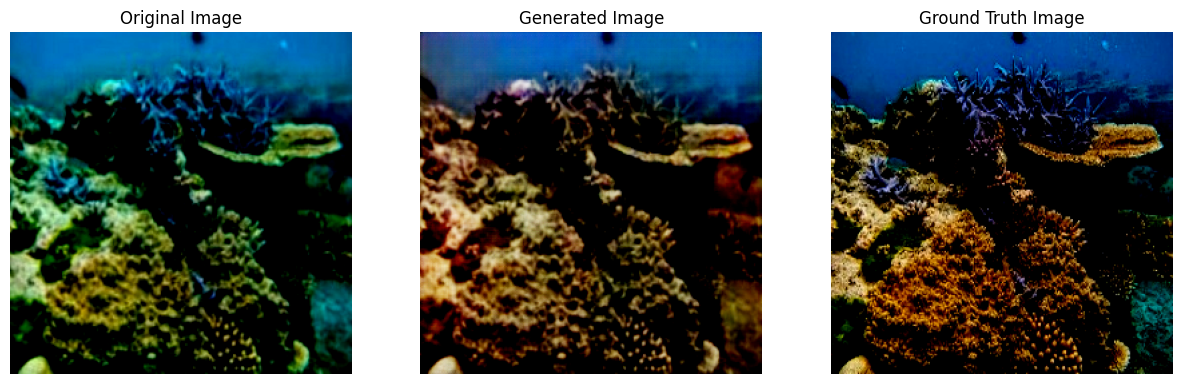

In [23]:
# Import necessary libraries
import tensorflow as tf
from matplotlib import pyplot as plt

# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256 
BATCH_SIZE = 64

# load the image and convert to tensor
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Convert image to float32 tensors
    image = tf.cast(image, tf.float32)

    return image

# resize to 256x256
def resize(image, height, width):
  resized_image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return resized_image

# random cropping
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# Normalizing the images to [-1, 1]
def normalize(image):
  normalized_image = (image / 127.5) - 1
  return normalized_image

# preprocessing steps
def load_image(image_file):
  image = load(image_file)
  #image = random_jitter(image)
  image = normalize(image)
  return image

def display_original_generated_ground_truth(original, generated, ground_truth):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original)
    plt.axis('off')

    # Display generated image
    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(generated)
    plt.axis('off')
    
    # Display ground truth image
    plt.subplot(1, 3, 3)
    plt.title('Ground Truth Image')
    plt.imshow(ground_truth)
    plt.axis('off')

    plt.show()


# Load the pre-trained weights of the generator model
generator.load_weights('/kaggle/working/training_1/cp.weights.h5')

# Load and preprocess the test image
test_image_path = '/kaggle/input/euvp-dataset/EUVP/test_samples/Inp/test_p106_.jpg'
test_image = load_test_image(test_image_path, IMG_HEIGHT, IMG_WIDTH)

# Load and preprocess the ground truth image
ground_truth_image_path = '/kaggle/input/euvp-dataset/EUVP/test_samples/GTr/test_p106_.jpg'
ground_truth_image = load_test_image(ground_truth_image_path, IMG_HEIGHT, IMG_WIDTH)


# Generate the enhanced image using the generator model
generated_image = generator(tf.expand_dims(test_image, axis=0), training=False)[0]

# Generate enhanced images using the generator model
generated_images = []
generated_batch = generator(tf.expand_dims(test_image, axis=0), training=False)
generated_images.append(generated_batch.numpy())

# Display original, generated, and ground truth images for qualitative evaluation
display_original_generated_ground_truth(test_image, generated_image, ground_truth_image)
